# Fully offline webscraper for manufacturing

### Imports

In [3]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Langchain setup
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_ollama import OllamaLLM
import json, re

#DDG
from duckduckgo_search import DDGS

# Fetching HTML
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Setup BLIP-2

Using BLIP-2 as captioning model

### To-do: Feed the image embeddings directly to the model

In [2]:
from huggingface_hub import snapshot_download
# this will cache everything under ~/.cache/huggingface/hub or in `cache_dir`
local_dir = snapshot_download(
  repo_id="Salesforce/blip2-opt-2.7b",
  repo_type="model",
  local_dir="./models/blip2-opt-2.7b",
  local_dir_use_symlinks=False
)
print("Saved to", local_dir)

/home/vinaylanka/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 40677.52it/s]

Saved to /home/vinaylanka/Desktop/manufacturing_final_project/models/blip2-opt-2.7b


In [3]:
# Hugging Face Image Captioning Model Setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model and feature extractor
# BLIP2 Image Captioning
repo_dir = "./models/blip2-opt-2.7b"   # wherever you snapshot_downloaded it

processor = Blip2Processor.from_pretrained(repo_dir, local_files_only=True)
model     = Blip2ForConditionalGeneration.from_pretrained(
               repo_dir,
               local_files_only=True,
               torch_dtype=torch.float16
            )

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


### Using BLIP-2 to generate captions

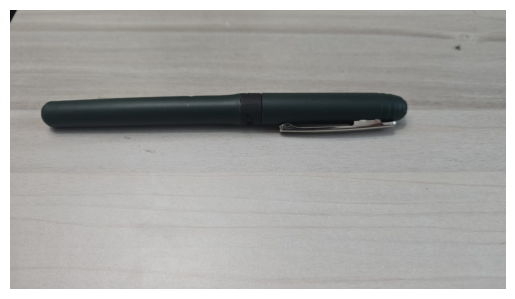

Question: What is the object in the image? Answer: a fountain pen. Question: What is the material of the pen? Answer: a plastic pen.


In [4]:
obj_img_path = 'obj.jpeg'

# Load the image with PIL
image = Image.open(obj_img_path)

# Display the image with matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes for better visualization
plt.show()

prompt = "Question: What is the object in the image? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to("cpu", torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
prompt = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip() + ". Question: What is the material of the pen? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to("cpu", torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

print(generated_text)

### Generate queries

Model - gemma3:4b



In [1]:
# Initialize your LLM
llm = OllamaLLM(model="gemma3:4b", temperature=0.3)

# Prompt template for queries
query_prompt = PromptTemplate.from_template("""
You are a manufacturing research assistant.
Given the object description below, generate {k} diverse DuckDuckGo
search queries that will retrieve:
  • step-by-step manufacturing guides  
  • sustainable material options  
  • cost analyses  

Return only a JSON array of query strings.

Description:
"{caption}"
""")

def generate_queries(caption: str, k: int = 6) -> list[str]:
    chain = LLMChain(llm=llm, prompt=query_prompt.partial(k=k))
    out_dict = chain.invoke({"caption": caption})
    raw      = out_dict["text"].strip()      # ← extract the string
    match    = re.search(r"\[.*\]", raw, re.DOTALL)
    if not match:
        raise ValueError(f"Could not parse JSON from model:\n{raw}")
    return [q.strip() for q in json.loads(match.group(0))]


NameError: name 'OllamaLLM' is not defined

In [8]:
queries = generate_queries(generated_text)
print("Generated queries:")
for q in queries:
    print(f"  • {q}")

Generated queries:
  • DIY fountain pen manufacturing process
  • sustainable pen materials cost analysis
  • eco-friendly pen production guide
  • plastic pen manufacturing cost breakdown
  • sustainable fountain pen design and fabrication
  • low-cost fountain pen prototyping techniques


### Duck-Duck-Go scraping for top N URLs

In [ ]:
def ddg_search(query: str, max_results: int = 5) -> list[str]:
    """
    Returns the top‑N DuckDuckGo result URLs for a query.
    """
    with DDGS() as ddgs:
        return [hit["href"] for hit in ddgs.text(query, max_results=max_results)]

# Example usage:
# urls = [u for q in queries for u in ddg_search(q, max_results=5)]
# urls = list(dict.fromkeys(urls))  # dedupe while preserving order

In [4]:
async def fetch_documents(urls: list[str]):
    """
    Asynchronously downloads each page and converts HTML→plain text.
    Returns a list of LangChain Document objects.
    """
    loader    = AsyncHtmlLoader(urls)
    html_docs = await loader.load()                       # list[Document] with HTML in .page_content
    transformer = Html2TextTransformer()                  # strips tags, yields markdown‑style text :contentReference[oaicite:0]{index=0}
    text_docs = transformer.transform_documents(html_docs)
    return text_docs


In [ ]:
all_urls = []
for q in queries:
    urls = ddg_search(q, max_results=5)
    print(f"\nQuery: {q}\n  URLs:")
    for u in urls:
        print("    •", u)
    all_urls.extend(urls)

unique_urls = list(dict.fromkeys(all_urls))
print(f"\nTotal unique URLs: {len(unique_urls)}")



Query: DIY fountain pen manufacturing process
  URLs:
    • https://www.madehow.com/Volume-7/Fountain-Pen.html
    • https://www.dayspringpens.com/blogs/the-jotted-line/how-fountain-pens-made
    • https://www.wikihow.com/Make-a-Pen
    • https://hogonext.com/how-to-make-a-pen/
    • https://fountainpenguide.com/how-to-make-a-fountain-pen/

Query: sustainable pen materials cost analysis
  URLs:
    • https://www.theenvironmentalblog.org/2025/03/bamboo-to-recycled-plastic-materials-green-pens/
    • https://jestec.taylors.edu.my/Special+Issue+ISCoE+2024_1/ISCoE2024_1_18.pdf
    • https://hingtungtech.com/abs-vs-pp-strategic-material-selection-for-pen-manufacturing/
    • https://open.library.ubc.ca/soa/cIRcle/collections/undergraduateresearch/18861/items/1.0108423
    • https://codesanitize.com/from-bamboo-to-recycled-plastic-the-supplies-behind-inexperienced-pens/

Query: eco-friendly pen production guide
  URLs:
    • https://www.theenvironmentalblog.org/2025/03/bamboo-to-recycled-pl

### Fetch HTML Docs as plain text
### Parsing plain-text

In [ ]:
N = 25
print(f"\nFetching and parsing first {N} pages:")
loader    = AsyncHtmlLoader(unique_urls[:N])
html_docs = loader.load()  # no await
transformer = Html2TextTransformer()
docs      = transformer.transform_documents(html_docs)

# 3) Inspect each Document
for i, doc in enumerate(docs, 1):
    src     = doc.metadata.get("source", "unknown")
    excerpt = doc.page_content.replace("\n", " ")[:10000]
    print(f"\nDocument {i} — source: {src}")
    print("Excerpt:", excerpt, "…")
    print("-" * 80)


Fetching and parsing first 25 pages:


Fetching pages:  40%|####      | 10/25 [00:19<00:05,  2.69it/s]Error fetching https://ecofriendlyguides.com/make-an-ecofriendly-pen/ with attempt 1/3: Connection timeout to host https://ecofriendlyguides.com/make-an-ecofriendly-pen/. Retrying...
Error fetching https://ecofriendlyguides.com/make-an-ecofriendly-pen/ with attempt 2/3: Connection timeout to host https://ecofriendlyguides.com/make-an-ecofriendly-pen/. Retrying...
Fetching pages:  40%|####      | 10/25 [01:41<02:31, 10.11s/it]


ConnectionTimeoutError: Connection timeout to host https://ecofriendlyguides.com/make-an-ecofriendly-pen/